## Lab4 : Spark ML : Logistic Regression Example

Logistic regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes.

### Concepts :

* Creating DataFrames from CSV input data format
* Performing basic data analysis using Spark SQL
* Using Spark ML to perform Logistic Regression

### Reference :
* Spark Reference Documentation : https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#logistic-regression 

### Input Dataset :

* Adults dataset : https://archive.ics.uci.edu/ml/datasets/Adult

### Objective :

* Build and train model that is able to predict whether income exceeds 50K/yr based on census data. Also known as "Census Income" dataset.

### Dataset Details:

Features:

* age: 
* workclass:
* fnlwgt:
* education: 
* education-num: 
* marital-status:
* occupation: 
* relationship: 
* race: 
* sex:
* capital-gain: 
* capital-loss: 
* hours-per-week: 
* native-country: 

Target :

* Income: >50K/yr, <=50K/yr.

### Overall Workflow

1. Load Data
2. Inspect Data
3. Preprocess Data
4. Create Model
5. Make Predictions
6. Evaluate how good are our predictions



In [1]:
import os
dataset_path="/user/common/adults_data/"
outputs_path=os.environ['HOME']

In [2]:
import findspark
findspark.init()
import pyspark

In [3]:
# Create a SparkSession and specify configuration
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("yarn") \
    .appName("Lab4-ML-LogisticRegression") \
    .getOrCreate()

### Load Data
 * use spark session to read the corresponding format and header + infer scheme (when possible)

In [4]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("hdfs://"+dataset_path+"train_data.csv")

In [5]:
# Cache
df.cache()

DataFrame[age: int, workclass: string, fnlwgt: double, education: string, education-num: double, marital-status: string, occupation: string, relationship: string, race: string, sex: string, capital-gain: double, capital-loss: double, hours-per-week: double, native-country: string, outcome: string]

In [6]:
# IF YOU WANT TO SEE A NICE TABLE
pd_df=df.toPandas()

In [7]:
pd_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [8]:
# Create a table for SQL access
df.registerTempTable("train_data")

### Inspect Data

* How many records do we have?
* What is the schema of our data?
* Is it numerical , is it categorical?
* Visualize your data

**Always** refer to the manuals:
Feature Extraction and Operation: https://spark.apache.org/docs/2.2.1/ml-features.html

In [9]:
print('Nb. of records  : %d' % df.count())

Nb. of records  : 32561


In [10]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: double (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: double (nullable = true)
 |-- capital-loss: double (nullable = true)
 |-- hours-per-week: double (nullable = true)
 |-- native-country: string (nullable = true)
 |-- outcome: string (nullable = true)



In [11]:
# Some stats on numerical features
df.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             32561|
|   mean| 38.58164675532078|
| stddev|13.640432553581356|
|    min|                17|
|    max|                90|
+-------+------------------+



Text(0.5,1,'Age Distribution')

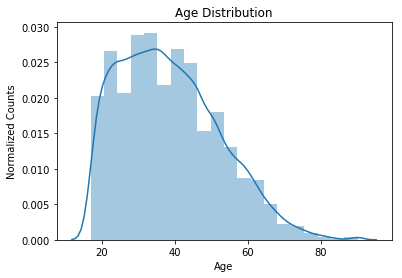

In [14]:
# Do some plots : for example , age distribution
import seaborn as sns
x=df.select('age').collect()
plt=sns.distplot(x,bins=20)
plt.set_xlabel('Age')
plt.set_ylabel('Normalized Counts')
plt.set_title('Age Distribution')

In [17]:
# How many distict workclass we have
# How many distict education we have
# How many distict occupation we have
df.select('workclass').distinct().collect()

[Row(workclass=' State-gov'),
 Row(workclass=' Federal-gov'),
 Row(workclass=' Self-emp-not-inc'),
 Row(workclass=' Local-gov'),
 Row(workclass=' Private'),
 Row(workclass=' ?'),
 Row(workclass=' Self-emp-inc'),
 Row(workclass=' Without-pay'),
 Row(workclass=' Never-worked')]

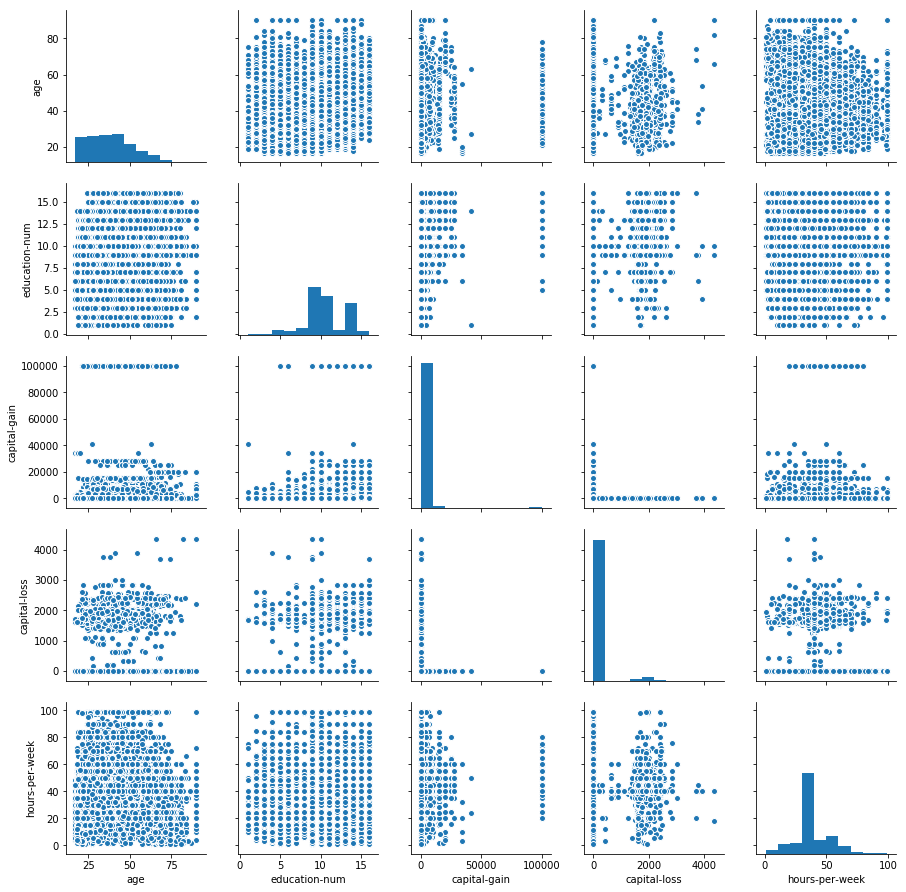

In [18]:
# Visualize , Visualize : do MOOORE PLOTS
numericCols = ['age', 'education-num','capital-gain','capital-loss','hours-per-week']
sns.pairplot(pd_df[numericCols], dropna=True)


### Preprocess Data

The data inspetion shows that our dataset contains categorical variables. 
For example : workclass , education ,      marital-status , occupation , relationship

#### Feature Transformation

Since models work over nunmerical values we have to transform  these variables into numeric representation. For this transformation process ( categorical -> numerical ) we will use the following 'functions':

 1. **StringIndexer** 
     https://spark.apache.org/docs/2.2.1/ml-features.html#stringindexer
     StringIndexer encodes a string column of labels to a column of label indices.

 2. **OneHotEncoder**: 
     https://spark.apache.org/docs/2.2.1/ml-features.html#onehotencoder
     OneHotEncoder maps a column of label indices to a column of binary vectors, with at most a single one-value.
     This encoding allows algorithms which expect continuous features, such as Logistic Regression, 
     to use categorical features.Each categorical column will be indexed using the StringIndexer, 
     and then converted nto one-hot encoded variables using the One-Hot encoder. 
     The resulting output has the binary vectors appended to the end of each row.
   
 3. **VectorAssembler**: 
     https://spark.apache.org/docs/2.2.1/ml-features.html#vectorassembler
     TBW

 4. **Pipelines** : 
    We will have more than 1 'process' or stage in our transforamtion so we use a **Pipeline** 
    to put stages   together. This greately 'cleans' the code elaboration.

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# For demonstration purposes , let's see how the indexer works
a_df=df.select('workclass').distinct()
indexer = StringIndexer(inputCol='workclass', outputCol='workclassIndex')
model = indexer.fit(a_df)
indexed = model.transform(a_df)
indexed.show()

+-----------------+--------------+
|        workclass|workclassIndex|
+-----------------+--------------+
|        State-gov|           8.0|
|      Federal-gov|           4.0|
| Self-emp-not-inc|           2.0|
|        Local-gov|           5.0|
|          Private|           3.0|
|                ?|           0.0|
|     Self-emp-inc|           1.0|
|      Without-pay|           6.0|
|     Never-worked|           7.0|
+-----------------+--------------+



In [20]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = [ \
           "workclass", "education", "marital-status", \
           "occupation", "relationship", "race", "sex", "native-country"]

stages = [] # stages in our Pipeline
for col in categoricalColumns:
  
  # Category Indexing with StringIndexer
  indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
   
  # Use OneHotEncoder to convert categorical variables into binary SparseVectors
  encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vector")
  
  # Add stages.  These are not run here, but will run all at once later on.
  stages += [indexer, encoder]

In [21]:
# Use StringIndexer to encode ALSO our target (income) to label indices.
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol = "outcome", outputCol = "label")
stages += [label_stringIdx]

#### VectorAssembler 
combine all the feature columns into a single vector column. 
Vector assembler can be used to combine raw features and features generated by different feature transformers 
into a single feature vector, in order to train ML models like logistic regression 
This output will include both the numeric columns and the one-hot encoded binary vector columns in our dataset.

In [22]:
# Transform all numerical features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
assemblerInputs = [ col + "_vector" for col in categoricalColumns ] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [23]:
print(assemblerInputs)

['workclass_vector', 'education_vector', 'marital-status_vector', 'occupation_vector', 'relationship_vector', 'race_vector', 'sex_vector', 'native-country_vector', 'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [24]:
# Check the stages of our pipeline
n=0
for s in stages:
    print('stage number %d %s' %(n,s.getOutputCol()))
    n+=1      

stage number 0 workclass_index
stage number 1 workclass_vector
stage number 2 education_index
stage number 3 education_vector
stage number 4 marital-status_index
stage number 5 marital-status_vector
stage number 6 occupation_index
stage number 7 occupation_vector
stage number 8 relationship_index
stage number 9 relationship_vector
stage number 10 race_index
stage number 11 race_vector
stage number 12 sex_index
stage number 13 sex_vector
stage number 14 native-country_index
stage number 15 native-country_vector
stage number 16 label
stage number 17 features


### Make Model
 * Create a Pipeline object to group together the stages we defined ( feature transformations )
 * Create the model
 * Split data into train and test data
 * Train the model with train data
 * Test model predictions with test data

In [25]:
from pyspark.ml import Pipeline
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.

transformer = pipeline.fit(df)
transformed_df = transformer.transform(df)

# Keep relevant columns
selection = ["label", "features", "age", "occupation"] + assemblerInputs
dataset = transformed_df.select(selection)

In [26]:
### Randomly split data into training (70%) and test (30%) sets. set seed for reproducibility
(train_data, test_data) = dataset.randomSplit([0.7, 0.3], seed = 100)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())
train_data.cache()

Training records : 22838
Test records : 9723 


DataFrame[label: double, features: vector, age: int, occupation: string, workclass_vector: vector, education_vector: vector, marital-status_vector: vector, occupation_vector: vector, relationship_vector: vector, race_vector: vector, sex_vector: vector, native-country_vector: vector, age: int, fnlwgt: double, education-num: double, capital-gain: double, capital-loss: double, hours-per-week: double]

In [27]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
model = lr.fit(train_data)

In [28]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.

predictions = model.transform(test_data)

In [29]:
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- occupation: string (nullable = true)
 |-- workclass_vector: vector (nullable = true)
 |-- education_vector: vector (nullable = true)
 |-- marital-status_vector: vector (nullable = true)
 |-- occupation_vector: vector (nullable = true)
 |-- relationship_vector: vector (nullable = true)
 |-- race_vector: vector (nullable = true)
 |-- sex_vector: vector (nullable = true)
 |-- native-country_vector: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education-num: double (nullable = true)
 |-- capital-gain: double (nullable = true)
 |-- capital-loss: double (nullable = true)
 |-- hours-per-week: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [30]:
# See model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select("label", "prediction", "probability", "age", "occupation")

In [31]:
selected.toPandas()

,label,prediction,probability,age,occupation
0,0.0,0.0,"[0.6923453279519433, 0.3076546720480568]",26,Prof-specialty
1,0.0,0.0,"[0.6211553145296423, 0.37884468547035766]",30,Prof-specialty
2,0.0,0.0,"[0.6584529417752994, 0.3415470582247006]",31,Prof-specialty
3,0.0,0.0,"[0.6582662002284263, 0.34173379977157375]",32,Prof-specialty
4,0.0,0.0,"[0.6150342380572296, 0.3849657619427704]",39,Prof-specialty
5,0.0,0.0,"[0.5398608213408302, 0.46013917865916976]",47,Prof-specialty
6,0.0,0.0,"[0.6004473238924508, 0.39955267610754913]",50,Prof-specialty
7,0.0,0.0,"[0.589862498197214, 0.41013750180278596]",51,Prof-specialty
8,0.0,0.0,"[0.5824187454881695, 0.4175812545118305]",60,Prof-specialty
9,0.0,0.0,"[0.5920153502136111, 0.407984649786389]",61,Prof-specialty


#### Evaluation Metrics:
https://spark.apache.org/docs/2.2.1/mllib-evaluation-metrics.html

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
score = evaluator.evaluate(predictions)
print('Score is : %03f' % score )

Score is : 0.901421


### Model Tuning

** READ THIS : ** : https://spark.apache.org/docs/2.2.1/ml-tuning.html

 * Parameter tunning parameters 
 * Inspect available parameters for tuning
 * We will use cross-validation for parameter tuning

** An interesting blog ** :https://www.oreilly.com/ideas/big-datas-biggest-secret-hyperparameter-tuning
 

In [33]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw p

#### Cross Validation :
will create a model for each combination of parameters in the grid specified and evaluate its result


In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#
# Create Parameters Grid for Cross Validation
#
# We use :
# 3 regularization param values (regParam)
# 3 values for maximum nb of iterations
# 2 values for elasticNetParam
# The grid will have 3 x 3 x 3 = 27 parameter settings to choose from. 


# Regularization Parameter: 

# (intuitively) is a penalty against complexity. 
# A bigger regParam penalizes "large" weight coefficients ,i.e, 
# tries to avoid our model model picking up "noise," or "deducting a pattern where there is none."
# tries to avoid OVERFITTING

# ElasticNetParam:
# read this : https://en.wikipedia.org/wiki/Elastic_net_regularization

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [37]:
# Create 3-fold CrossValidator
# numFold sdetermines the number of train/test dataset pairs used ßin the cross-validation
# The cross validation will compute the average evaluation metric for the 3 Models
# produced by fitting the Estimator on the 3 different (training, test) dataset pairs.

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
cvModel = cv.fit(train_data)
# this may take some of time (depends on the amount of models that we're creating and testing)

In [38]:
# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(test_data)
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
best_score=evaluator.evaluate(predictions)
print('Best model score : %03f' % best_score)

Best model score : 0.899166


In [ ]:
spark.stop()